In [1]:
!pip install plotly
!pip install ggplot
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from ggplot import *
plotly.tools.set_credentials_file(username='willcuratolo', api_key='dCizVSpAQc5MhQ8KDKTn')

/usr/local/envs/py3env/lib/python3.5/site-packages/ggplot/components/smoothers.py:4: FutureWarning:

The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



# NYC Taxi Cab Fare Prediction
## Group 9
![Image of Taxi](https://images.hgmsites.net/lrg/new-york-city-taxi-cab_100166877_l.jpg)

# Introduction
In recent years, rideshare apps like Uber and Lyft have taken over the market from traditional taxi cabs.  However, in New York City specifically, the yellow cab is still a fixture of both popular culture and daily life.  One reason that Uber is often preferred to a yellow cab is that when you select your destination on Uber you instantly know the cost of the trip. However, with a yellow cab you get in the cab and you have to wait until the desination to know the cost of your trip.  As a traveller, that means you have to take a risk.  Additionally, taxi fares are notoriously difficult to understand.  They vary based on distance, number of passengers, idle time, and much more.  What if it was possible to accurately predict the cost of your trip in a yellow cab before you even got in?  

In this project we will explore the dataset of all NYC yellow cab rides in 2015 and then build a model to predict the cost of taxi trips.

# Data Exploration


First lets check out the size of the data set.  This is only for the year 2015, and its 19GB.

In [2]:
%%bq dryrun
SELECT *
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
LIMIT 20

What about the average trip length?

In [3]:
%%bq query
SELECT DATE(pickup_datetime) AS date, AVG(trip_distance) AS avg_trip_distance
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
GROUP BY 1
ORDER BY 2

date,avg_trip_distance
2015-02-07,-79.93866944453575
2015-02-05,-67.36224298862236
2015-03-23,-41.635448427449084
2015-01-27,2.2226348339483395
2015-01-07,2.6289844362776464
2015-01-26,2.6330668606544916
2015-01-08,2.6446013927082426
2015-01-17,2.668375951865143
2015-02-21,2.6687703411179946
2015-01-13,2.670525331258349


It looks like there are certain days where there is negative average trip distance.  This makes no sense.  When we query our data for the model we will want to make sure we exclude trips with negative trip distance.

## Drop Off Points
First, I want to visualize where the most popular drop off locations are.

In [4]:
%%bq query --name popular_dropoffs
SELECT ROUND(dropoff_latitude, 4) as latitude, ROUND(dropoff_longitude, 4) as longitude, COUNT(*) as dropoffs 
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
GROUP BY latitude, longitude

In [5]:
popular_dropoffs_df = popular_dropoffs.execute(output_options=bq.QueryOutput.dataframe()).result()

Lets examine the most popular trips.

In [6]:
popular_dropoffs_df.sort_values(by = ['dropoffs'], ascending = False).head()

,latitude,longitude,dropoffs
380803,0.0000,0.0000,2212402
173854,40.7504,-73.9947,44626
348199,40.7501,-73.9949,40946
187194,40.7684,-73.8618,31819
265154,40.7606,-74.0027,31332


By far the most popular dropoff location seems to have latitude and longitude zero.  But this doesn't make any sense.  It must be what happens when there is no trip data.  We will have to keep this in mind when we query our data for the final model.  Now lets plot the most popular dropoff locations.

In [26]:
df_slice = popular_dropoffs_df.sort_values(by = ['dropoffs'], ascending = False)[1:11]
latitudes = list(df_slice['latitude'])
longitudes = list(df_slice['longitude'])


In [8]:
mapbox_access_token = 'pk.eyJ1Ijoid2lsbGN1cmF0b2xvIiwiYSI6ImNqb25sZWlobzEzZXczcG80Mzdnd3JuOTQifQ.JCYLDqeJ2TdZf5cXj0E4xA'

data = [
    go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode='markers',
        marker=dict(
            size=14
        ),
        text=['Most Popular Dropoff Point', '2nd Most Popular',
             '3rd Most Popular', '4th Most Popular',
             '5th Most Popular', '6th Most Popular',
             '7th Most Popular', '8th Most Popular',
             '9th Most Popular', '10th Most Popular',
             ],
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.7504,
            lon=-73.9947
        ),
        pitch=0,
        zoom=11
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='NYC2')

So we see a lot of points around Penn Station, LaGuardia Airport, and the Ferry center on the West side of Manhattan.

## Pick Up Locations
Next, I want to quickly visualize where the most popular pick up locations are.

In [9]:
%%bq query --name popular_pickups
SELECT ROUND(pickup_latitude, 4) as latitude, ROUND(pickup_longitude, 4) as longitude, COUNT(*) as pickups 
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
GROUP BY latitude, longitude

In [10]:
popular_pickups_df = popular_pickups.execute(output_options=bq.QueryOutput.dataframe()).result()

In [11]:
popular_pickups_df.sort_values(by = ['pickups'], ascending = False).head()

,latitude,longitude,pickups
794644,0.0000,0.0000,2305096
732081,40.7741,-73.8745,110886
801517,40.6454,-73.7767,97101
888596,40.7512,-73.9941,92326
761980,40.7738,-73.8709,83508


Once again we have the issue with latitude and longitude (0,0), so we must exclude that data later.  But lets plot the other top pickup spots.

In [12]:
df_slice = popular_pickups_df.sort_values(by = ['pickups'], ascending = False)[1:11]
latitudes = list(df_slice['latitude'])
longitudes = list(df_slice['longitude'])

In [13]:
data = [
    go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode='markers',
        marker=dict(
            size=14
        ),
        text=['Most Popular Pickup Point', '2nd Most Popular',
             '3rd Most Popular', '4th Most Popular',
             '5th Most Popular', '6th Most Popular',
             '7th Most Popular', '8th Most Popular',
             '9th Most Popular', '10th Most Popular',
             ],
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.7504,
            lon=-73.9947
        ),
        pitch=0,
        zoom=11
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='NYC3')

So we can see that the popular pickup points and the popular dropoff points overlap almost entirely and focus on the busiest transportation hubs like airports, train stations, and ferry docks.  

The most popular pickup spot was from LaGuardia Airport, and the most popular dropoff spot was at Penn Station, a trip of 8.9 miles.

In [4]:
from google.datalab import Context
from tabulate import tabulate
import pandas as pd
import google.datalab.bigquery as bq
import google.datalab.storage as storage
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

from matplotlib import font_manager
from google.datalab.ml import FacetsOverview
from google.datalab.ml import BigQueryDataSet
from io import StringIO
from io import BytesIO 
import cStringIO
import google.datalab.contrib.mlworkbench.commands

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
warnings.filterwarnings('ignore')
import h5py

NameError: name 'warnings' is not defined

# DATA PREP

To predict the NYC taxi fare amount, we tried to account for as many variables as possible. Thus, we selected factors such as pick up and drop off coordinates, pick_up time, passenger count, rate code, and trip distance. We made sure that we obtained only the observations with fare_amount greater than $2.5, which is the minimum taxi fare in NYC. We also set the condition "IS NOT NULL" for the other variables we selected to avoid incomplete data.  Using Google big query, we queried our data from the public dataset. In addition, we saved the schema for the result to provide appropriate categorazation for our variables. 

In [6]:
%%bq query --name nyc_taxi 
SELECT
  fare_amount,
  CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM pickup_datetime) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) as hour,
  passenger_count,
  rate_code, 
  trip_distance, 
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude
FROM 
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE 
  fare_amount > 2.5 AND 
  pickup_latitude IS NOT NULL  AND
  pickup_longitude IS NOT NULL AND
  dropoff_latitude IS NOT NULL AND
  dropoff_longitude IS NOT NULL AND 
  trip_distance IS NOT NULL AND  
  passenger_count IS NOT NULL AND 
  rate_code IS NOT NULL 

data = BigQueryDataSet(table = 'bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015')
result = job.result()
data_schema = result.schema

# Sampling 

The returned data was too large too handle, so we decided to use only part of it.
By sampling 0.3% of the entire data, we managed to create data set over 200000 observations which was sufficient.  
We divided this sampling data into  95% training set and  5% evaluation set, resulting 195848 instances for training set and 10213 instances for evaluation set. Then we created directory and saved our datasets as csv files.  

In [7]:


sampling = bq.Sampling.random(percent=0.3)
job = nyc_taxi.execute(sampling=sampling)
df = job.result().to_dataframe()
msk = np.random.rand(len(df)) < 0.95
train_df = df[msk]
eval_df = df[~msk]


In [8]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 195848 instances.
Eval set includes 10213 instances.


In [9]:
!mkdir -p ./nyc_taxi  

In [10]:
train_df.to_csv('./nyc_taxi/train.csv', header=False, index=False)
eval_df.to_csv('./nyc_taxi/eval.csv', header=False, index=False)



# Dataset Creation & Exploration

To create dataset for model building, we used the saved schema to provided appropriate categorization for the dataset. 
Then we conducted comprehensive exploration using %%ml command explore.

In [11]:
%%ml dataset create
format: csv
train: ./nyc_taxi/train.csv
eval: ./nyc_taxi/eval.csv
name: nyc_taxi_data
schema: $data_schema


In [12]:
%%ml dataset explore --overview
name: nyc_taxi_data

train data instances: 195848
eval data instances: 10213
Sampled 1000 instances for each.


In [13]:
%%ml dataset explore --facets
name: nyc_taxi_data

train data instances: 195848
eval data instances: 10213
Sampled 1000 instances for each.


# Model Building 

In [14]:
!rm -r -f ./nyc_taxi/analysis # Delete previous run results.

# Step 1 : Analyze 

We used %%ml analyze to set the target variable as fare_amount and assigned appropriate transformation format for other variables.

In [17]:
%%ml analyze
output: ./nyc_taxi/analysis
data: $nyc_taxi_data
features:
  fare_amount:
    transform: target   
  weekday:
    transform: one_hot
  day:
    transform: one_hot
  hour:
    transform: one_hot
  pickup_latitude:
    transform: scale    
  pickup_longitude:
    transform: scale
  dropoff_latitude:
    transform: scale
  dropoff_longitude:
    transform: scale
  rate_code:
    transform: scale
  passenger_count:
    transform: scale
  trip_distance:
    transform: scale
    
    

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_regression_taxi/nyc_taxi/train.csv...
file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_regression_taxi/nyc_taxi/train.csv analyzed.


# Step 2 : Transform
We converted our data to special TensorFlow file called a TFRecord file for the faster processing. 

In [18]:
!rm -r -f ./nyc_taxi/transform # Delete previous run results.

In [19]:
%%ml transform
output: ./nyc_taxi/transform
analysis: ./nyc_taxi/analysis
data: $nyc_taxi_data

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/optimize/_minimize.py:32: ImportWarning: Not importing directory '/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb
/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: ImportWarning: Not importing directory '/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future,

## After the traformatiom, we defined our transformed dataset. 

In [20]:
%%ml dataset create
format: transformed
name: nyc_taxi_transformed
train: ./nyc_taxi/transform/train-*
eval: ./nyc_taxi/transform/eval-*


In [21]:
%%ml dataset explore
name: nyc_taxi_transformed

train data instances: 195848
eval data instances: 10213


In [22]:
!rm -r -f ./nyc_taxi/dnn_train 

# DNN Regression Model 
Using the transformed dataset, we built out DNN model. 
In order to account for all of the combinations from our data, we set two hidden layers for this model and assinged size 200 and 100 for each.
The model will run untill it detects that evaluation loss is no longer decreasing. 

In [47]:
%%ml train 
output: ./nyc_taxi/dnn_train
analysis: ./nyc_taxi/analysis
data: $nyc_taxi_transformed
model_args:
    model: dnn_regression
    hidden-layer-size1: 200
    hidden-layer-size2: 100


TensorBoard was started successfully with pid 67364. Click here to access it.

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Model evaluation 
After testing, the RMSE for this model result in 4.70951.  In a practical setting, this means our model can predict, on average, the correct fare within five dollars.  For shorter trips this could be an issue, but for longer trips it is very useful.  The dataset covers all of New York City's five boroughs, and so this would definitely be useful if you are going from, say, Queens to Manhattan.   Also, given the wide variety of factors that go into taxi trips and the sometimes questionable quality of the data, our model's performance seems fairly impressive.

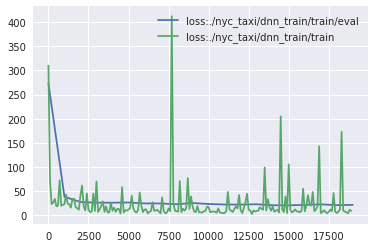

In [41]:
from google.datalab.ml import Summary

summary = Summary('./nyc_taxi/dnn_train')
summary.plot('loss')

In [52]:
!rm -r -f ./nyc_taxi/batch_predict # Delete previous results.

In [53]:
!ls ./nyc_taxi/dnn_train/

evaluation_model  model  schema_without_target.json  train


In [54]:
%%ml batch_predict
model: ./nyc_taxi/dnn_train/evaluation_model/
output: ./nyc_taxi/batch_predict
format: csv
data:
  csv: ./nyc_taxi/eval.csv  

local prediction...
INFO:tensorflow:Restoring parameters from ./nyc_taxi/dnn_train/evaluation_model/variables/variables
done.


In [55]:
%%ml evaluate regression
csv: ./nyc_taxi/batch_predict/predict_results_eval.csv

,metric,value
0,Root Mean Square Error,4.709517
1,Mean Absolute Error,2.506592
2,50 Percentile Absolute Error,1.815311
3,90 Percentile Absolute Error,4.782005
4,99 Percentile Absolute Error,12.643192


In [46]:
%%ml evaluate accuracy
csv: ./nyc_taxi/batch_predict/predict_results_eval.csv

,accuracy,count,target
0,0.0,41,3
1,0.0,136,3.5
2,0.0,220,4
3,0.0,297,4.5
4,0.0,1,4.8
5,0.0,413,5
6,0.0,450,5.5
7,0.0,492,6
8,0.0,0,6.11445
9,0.0,0,6.11733


# Local prediction & Conclusion 

In [36]:
%%ml predict
model: ./nyc_taxi/dnn_train/model/
data:  
- 1, 180, 12, 2, 1, 8.9, 40.7684, -73.8618, 40.7504, -73.9947
- 3, 74, 6, 1, 1, 16, 40.6437, -73.7836, 40.7648, -73.9742
- 4, 20, 22, 3, 1, 4.6, 40.7588, -73.9848, 40.7124, -74.0131
- 6, 364, 18, 2, 1, 16.6, 40.6437, -73.7836, 40.7588, -73.9848

predicted,day,dropoff_latitude,dropoff_longitude,hour,passenger_count,pickup_latitude,pickup_longitude,rate_code,trip_distance,weekday
32.596397,180,40.7504,-73.9947,12,2,40.7684,-73.8618,1,8.9,1
48.023247,74,40.7648,-73.9742,6,1,40.6437,-73.7836,1,16,3
22.507772,20,40.7124,-74.0131,22,3,40.7588,-73.9848,1,4.6,4
49.629761,364,40.7588,-73.9848,18,2,40.6437,-73.7836,1,16.6,6


The four trips we chose to predict are typical routes a tourist might take where they would choose between an Uber or a Taxi.  They are: LaGuardia Airport to Penn Station, JFK Airport to The Plaza Hotel, Times Square to the One World Trade Center Memorial, and JFK Airport to Times Square. If a tourist wants to call a Taxi from LaGuardia Airport to Penn Station on Monday at 5PM with a total of 2 passengers, it will cost him about \\$32.60. If a tourist wants to go from JFK Airport to the Plaza Hotel on Wednesday at 6PM with only one passenger, it would cost him about \\$48.02. If a tourist wants to go from Times Squres to the One World Trade Center Memorial on Thurday at 10PM with a total of 3 passengers, it would cost him about \\$22.51. Lastly, if he wants to go from JFK Airport to Times Squre on Saturday at 6PM with a total of 2 passengers, it would cost him about \\$49.63. Here, we learned that predicting taxi fares can be really useful because if a tourist can predict the price before the trip starts, he or she can decide whether to take a cheaper transportation or walk rather than riding in an Uber or taxi.



Footnote: Some of the code for the visualizations was adapted from the previous Cloud project done by Will Curatolo.